# Get a LSST Simulated Cadence for Arbitrary Sky Position
___


___

In [4]:
"""

"""
%matplotlib inline

from __future__ import print_function

try:
    from importlib import reload
except:
    pass


from matplotlib import pyplot as plt
import matplotlib.colors as mpl_colors 

import os
import warnings

import numpy as np
import pandas as pd
import astropy as ap
import sfdmap

import sqlite3
from sqlalchemy import create_engine

from astropy import units as u
from astropy.coordinates import SkyCoord

import lsst_tools.utils as utils 
import lsst_tools.utils.colours as colours 

import pyCoCo as pccsims

Connect to .db file that contains the opsim output, read into a dataframe, `opsimdf`

In [5]:
# %%timeit ## 1 loop, best of 3: 1min 31s per loop 
# opsimdbpath = os.environ.get('OPSIMDBPATH')
# print(opsimdbpath)
opsimdbpath = "/Users/berto/data/LSST/OpSimOutputDBs/astro_lsst_01_1068_sqlite.db"

conn = create_engine('sqlite:///'+opsimdbpath, echo = False)
opsimdf = pd.read_sql_table('Summary', con=conn)

In [6]:
opsimdf

,obsHistID,sessionID,propID,fieldID,fieldRA,fieldDec,filter,expDate,expMJD,night,...,moonBright,darkBright,rawSeeing,wind,humidity,slewDist,slewTime,fiveSigmaDepth,ditheredRA,ditheredDec
0,1,1068,227,505,1.720374,-0.936476,y,2922,59580.033829,0,...,0.000000,105.043185,0.920473,0.0,0.0,1.659226,0.000000,21.013506,1.694604,-0.962927
1,2,1068,227,567,1.648235,-0.903353,y,2961,59580.034278,0,...,0.000000,101.373243,0.920473,0.0,0.0,0.054827,4.769109,21.058304,1.623562,-0.929804
2,3,1068,227,561,1.563788,-0.915583,y,3000,59580.034726,0,...,0.000000,98.042992,0.920473,0.0,0.0,0.053275,4.780469,21.099047,1.538724,-0.942034
3,4,1068,227,539,1.477422,-0.924531,y,3039,59580.035175,0,...,0.000000,95.139389,0.920473,0.0,0.0,0.053066,4.762092,21.134714,1.452062,-0.950982
4,5,1068,227,531,1.389669,-0.930365,y,3077,59580.035623,0,...,0.000000,92.619319,0.920473,0.0,0.0,0.052952,4.739055,21.165823,1.364111,-0.956816
5,6,1068,227,517,1.301075,-0.933239,y,3116,59580.036071,0,...,0.000000,90.448151,0.920473,0.0,0.0,0.052904,4.709074,21.192773,1.275418,-0.959690
6,7,1068,227,519,1.212198,-0.933238,y,3155,59580.036519,0,...,0.000000,88.596990,0.920473,0.0,0.0,0.052892,4.669665,21.215880,1.186541,-0.959689
7,8,1068,227,523,1.123604,-0.930366,y,3193,59580.036967,0,...,0.000000,87.040118,0.920473,0.0,0.0,0.052904,4.742319,21.235417,1.098046,-0.956817
8,9,1068,227,541,1.035849,-0.924530,y,3233,59580.037422,0,...,0.000000,85.753276,0.920473,0.0,0.0,0.052953,5.250509,21.251646,1.010489,-0.950981
9,10,1068,227,698,0.988892,-0.827713,y,3272,59580.037880,0,...,0.000000,83.013952,0.920473,0.0,0.0,0.101357,5.588682,21.286460,0.966319,-0.854164


In [7]:
#%%timeit ## The slowest run took 39.04 times longer than the fastest. This could mean that an intermediate result is being cached.
#         ## 1000 loops, best of 3: 246 µs per loop
n = 1
pos_df = utils.generate_coordinates(n)

Add extinction to the dataframe

In [8]:
#%%timeit ## 1 loop, best of 3: 88.6 ms per loop
df = utils.find_MW_extinction(pos_df) 

Check the positions are sensible

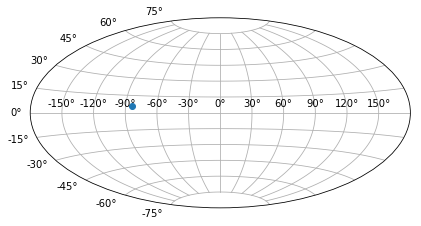

In [19]:
#%%timeit ## 1 loop, best of 3: 235 ms per loop
utils.plot_position_points(df)

Connecting to `.db` takes ages (~1min), and is a pain if you mess up, so create a 'working' instance to fiddle with

In [16]:
working_df = opsimdf

## Identifying Fields
___
We want to find out which field(s) the position is in. Create table that tells us the field centres, and find the edges.

In [17]:
# working_df = utils.get_field_corners(working_df.drop_duplicates("fieldID"))[['fieldRA', 'fieldDec']]
working_df = utils.get_field_corners(pd.DataFrame(working_df.drop_duplicates("fieldID"))[['fieldID', 'fieldRA', 'fieldDec']])

In [18]:
working_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
0,505,1.720374,-0.936476,1.750917,1.689831,-0.967019,-0.905933
1,567,1.648235,-0.903353,1.678778,1.617692,-0.933896,-0.872810
2,561,1.563788,-0.915583,1.594331,1.533245,-0.946126,-0.885040
3,539,1.477422,-0.924531,1.507965,1.446879,-0.955074,-0.893988
4,531,1.389669,-0.930365,1.420212,1.359126,-0.960908,-0.899822
5,517,1.301075,-0.933239,1.331618,1.270532,-0.963782,-0.902696
6,519,1.212198,-0.933238,1.242741,1.181655,-0.963781,-0.902695
7,523,1.123604,-0.930366,1.154147,1.093061,-0.960909,-0.899823
8,541,1.035849,-0.924530,1.066392,1.005306,-0.955073,-0.893987
9,698,0.988892,-0.827713,1.019435,0.958349,-0.858256,-0.797170


In [20]:
field_df = working_df[(working_df["RA_upper"] >= df["theta"][0] + np.pi) &
                (working_df["RA_lower"] <= df["theta"][0] + np.pi) &
                (working_df["Dec_lower"] >= df["phi"][0])  &
                (working_df["Dec_upper"] <= df["phi"][0])]

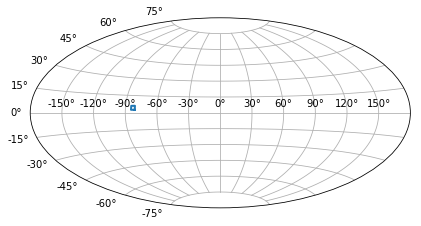

In [22]:
reload(utils)
utils.plot_field(field_df)

In [23]:
field_df

,fieldID,fieldRA,fieldDec,RA_upper,RA_lower,Dec_upper,Dec_lower
8190,2846,1.694772,0.076277,1.725315,1.664229,0.045734,0.106820
8816,2956,1.668941,0.118663,1.699484,1.638398,0.088120,0.149206


In [65]:
mjd_to_sim = opsimdf.loc[opsimdf["fieldID"] == 2846,["expMJD"]].values.T[0]
filters_to_sim = opsimdf.loc[opsimdf["fieldID"] == 2846,["filter"]].values.T[0]
filters_to_sim = np.array([b('LSST_'+x) for x in filters_to_sim])

In [62]:
mjdmax = np.random.choice(mjd_to_sim)

In [63]:
mjdmax

62481.287549000001

In [59]:
filters_to_sim

[b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_g',
 b'LSST_g',
 b'LSST_g',
 b'LSST_i',
 b'LSST_z',
 b'LSST_i',
 b'LSST_i',
 b'LSST_r',
 b'LSST_r',
 b'LSST_r',
 b'LSST_i',
 b'LSST_i',
 b'LSST_i',
 b'LSST_i',
 b'LSST_i',
 b'LSST_i',
 b'LSST_i',
 b'LSST_g',
 b'LSST_g',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_i',
 b'LSST_i',
 b'LSST_r',
 b'LSST_r',
 b'LSST_r',
 b'LSST_r',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_i',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_r',
 b'LSST_r',
 b'LSST_r',
 b'LSST_r',
 b'LSST_i',
 b'LSST_i',
 b'LSST_z',
 b'LSST_g',
 b'LSST_g',
 b'LSST_g',
 b'LSST_g',
 b'LSST_i',
 b'LSST_i',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'LSST_z',
 b'L

In [44]:
import pyCoCo as pccsims

In [45]:
import sys
if sys.version_info < (3,):
    def b(x):
        return x
else:
    import codecs
    def b(x):
        return codecs.latin_1_encode(x)[0]

In [46]:
filter_path = "/Users/berto/Code/CoCo/data/filters"
coco_root_path = "/Users/berto/Code/CoCo"


coco = pccsims.pyCoCo(b(filter_path), b(coco_root_path))

In [ ]:
# mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
# filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
# mjd_to_sim = 
# filters_to_sim = 

In [60]:
z_obs = 0.007


In [68]:
out = coco.simulate(b"SN2009jf", 
                    z_obs, -0.1, 0.5, 0.5, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [69]:
out

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [70]:
# mjdmax = testmjd[w[0]][0]
z_obs = 0.007
# mjd_to_sim = np.array(sn.phot.phot["MJD"])
# filters_to_sim = np.array([b(i.astype(str)) for i in sn.phot.phot["filter"]])

mjdmax = 100.0
mjd_to_sim = np.array([90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 105.0, 110.0, 115.0, 120.0])
filters_to_sim = np.array([b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r', b'SDSS_r'])
print(mjdmax)
print(mjd_to_sim)
print(filters_to_sim)

100.0
[  90.   91.   92.   93.   94.   95.   96.   97.   98.   99.  100.  105.
  110.  115.  120.]
[b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r'
 b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r' b'SDSS_r'
 b'SDSS_r']


In [71]:
out = coco.simulate(b"SN2009jf", 
                    z_obs, -0.0, 0.5, 0.5, 3.1, 
                    mjdmax, mjd_to_sim, 
                    filters_to_sim)

In [72]:
out

array([[  4.37446938e-14,   4.44413074e-14,   4.50550278e-14,
          4.55879591e-14,   4.60424068e-14,   4.64208423e-14,
          4.67258715e-14,   4.69602071e-14,   4.71266429e-14,
          4.72280315e-14,   4.72672638e-14,   4.66328661e-14,
          4.48741138e-14,   4.23188619e-14,   3.92491926e-14],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])